<a href="https://colab.research.google.com/github/shoyell/lecture_pytorch/blob/master/lecture6/train_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# モデルの訓練
画像識別アプリで使用する、CNNのモデルを訓練し保存します。  
今回は訓練データにCIFAR-10を使用します。  


## データの前処理
CIFAR-10を読み込んで、データ拡張とともにDataLoaderの設定を行います。  

In [1]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

affine = transforms.RandomAffine([-15, 15], scale=(0.8, 1.2))  # 回転とリサイズ
flip = transforms.RandomHorizontalFlip(p=0.5)  # 左右反転
normalize = transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))  # 平均値を0、標準偏差を1に
to_tensor = transforms.ToTensor()

transform_train = transforms.Compose([affine, flip, to_tensor, normalize])
transform_test = transforms.Compose([to_tensor, normalize])
cifar10_train = CIFAR10("./data", train=True, download=True, transform=transform_train)
cifar10_test = CIFAR10("./data", train=False, download=True, transform=transform_test)

# DataLoaderの設定
batch_size = 64
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=len(cifar10_test), shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 43.1MB/s]


## モデルの構築
`nn.Module`モジュールを継承したクラスとして、CNNのモデルを構築します。   

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 畳み込み層:(入力チャンネル数, フィルタ数、フィルタサイズ)
        self.pool = nn.MaxPool2d(2, 2)  # プーリング層:（領域のサイズ, ストライド）
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 256)  # 全結合層
        self.dropout = nn.Dropout(p=0.5)  # ドロップアウト:(p=ドロップアウト率)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

net = Net()
net.cuda()  # GPU対応
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


## 学習
モデルを訓練します。   
学習には時間がかかりますので、編集→ノートブックの設定のハードウェアアクセラレーターでGPUを選択しましょう。


In [5]:
from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# 最適化アルゴリズム
optimizer = optim.Adam(net.parameters())

# 損失のログ
record_loss_train = []
record_loss_test = []

# 学習
# x_test, t_test = iter(test_loader).next()
x_test, t_test = next(iter(test_loader))
x_test, t_test = x_test.cuda(), t_test.cuda()
for i in range(20):  # 20エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す
        x, t = x.cuda(), t.cuda()  # GPU対応
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    net.eval()  # 評価モード
    y_test = net(x_test)
    loss_test = loss_fnc(y_test, t_test).item()
    record_loss_test.append(loss_test)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 1.8074552124113683 Loss_Test: 1.559195876121521
Epoch: 1 Loss_Train: 1.5645972238782118 Loss_Test: 1.4145050048828125
Epoch: 2 Loss_Train: 1.483388557001148 Loss_Test: 1.3736826181411743
Epoch: 3 Loss_Train: 1.437390205500376 Loss_Test: 1.2953330278396606
Epoch: 4 Loss_Train: 1.4082269128936027 Loss_Test: 1.267806887626648
Epoch: 5 Loss_Train: 1.3763981992021546 Loss_Test: 1.229567527770996
Epoch: 6 Loss_Train: 1.3641410067563167 Loss_Test: 1.2870978116989136
Epoch: 7 Loss_Train: 1.3398704519662101 Loss_Test: 1.1992602348327637
Epoch: 8 Loss_Train: 1.319702959655191 Loss_Test: 1.1929619312286377
Epoch: 9 Loss_Train: 1.3053389368459696 Loss_Test: 1.1569980382919312
Epoch: 10 Loss_Train: 1.286143603074886 Loss_Test: 1.1291604042053223
Epoch: 11 Loss_Train: 1.276727690416224 Loss_Test: 1.1602822542190552
Epoch: 12 Loss_Train: 1.269459487532106 Loss_Test: 1.1612188816070557
Epoch: 13 Loss_Train: 1.2520128433661692 Loss_Test: 1.1160529851913452
Epoch: 14 Loss_Train: 1.2

## 誤差の推移
訓練データ、テストデータで誤差の推移をグラフ表示します。  

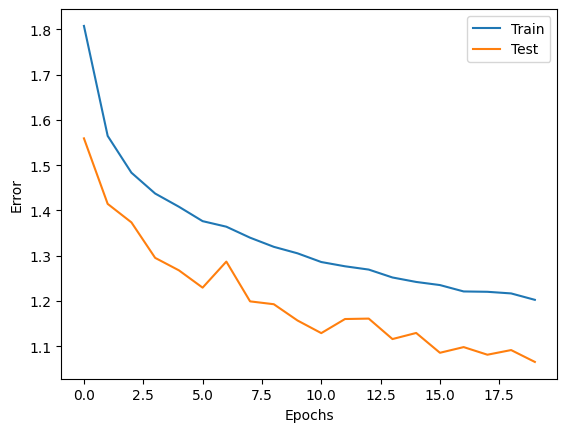

In [6]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## 正解率
モデルの性能を把握するため、テストデータ使い正解率を測定します。  

In [7]:
correct = 0
total = 0
net.eval()  # 評価モード
for i, (x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda()  # GPU対応
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)
print("正解率:", str(correct/total*100) + "%")

正解率: 62.519999999999996%


## モデルの保存
訓練済みモデルのパラメータを保存します。    
`state_dict()`によりモデルの各パラメータが取得できるので、これを保存します。

In [8]:
import torch

# state_dict()の表示
for key in net.state_dict():
    print(key, ": ", net.state_dict()[key].size())
print(net.state_dict()["conv1.weight"][0])  # 　パラメータの一部を表示

# 保存
torch.save(net.state_dict(), "model_cnn.pth")

conv1.weight :  torch.Size([6, 3, 5, 5])
conv1.bias :  torch.Size([6])
conv2.weight :  torch.Size([16, 6, 5, 5])
conv2.bias :  torch.Size([16])
fc1.weight :  torch.Size([256, 400])
fc1.bias :  torch.Size([256])
fc2.weight :  torch.Size([10, 256])
fc2.bias :  torch.Size([10])
tensor([[[-0.1093,  0.0251, -0.0556, -0.0406,  0.0285],
         [ 0.0511,  0.0101,  0.1117,  0.0451, -0.0853],
         [-0.0969, -0.0499,  0.0126,  0.0700,  0.0392],
         [ 0.0218, -0.0942,  0.0735, -0.1363, -0.1062],
         [-0.1072,  0.0291, -0.0703, -0.1144, -0.0091]],

        [[ 0.0542,  0.0641,  0.0525,  0.0417, -0.0904],
         [-0.0147,  0.0286,  0.1203,  0.0402, -0.0634],
         [ 0.1292,  0.0446,  0.0658, -0.0378, -0.0131],
         [ 0.0576,  0.1004,  0.0208,  0.0954, -0.1151],
         [ 0.0254, -0.0483,  0.0155, -0.0978, -0.0406]],

        [[-0.1039, -0.0262,  0.1128,  0.1248,  0.0770],
         [ 0.0768,  0.1638, -0.0147,  0.1352,  0.1061],
         [-0.0287,  0.1337,  0.1303,  0.0474,  0

## モデルの読み込み
保存したパラメータを読み込み、モデルに設定します。  
`torch.load()`で`map_location`にCPUを指定することで、GPUで訓練したモデルをCPUで使用することが可能になります。  


In [9]:
# 読み込み
net_loaded = Net()
net_loaded.load_state_dict(torch.load("model_cnn.pth", map_location=torch.device("cpu")))  #CPU対応
net_loaded.eval()  # 評価モード

# state_dict()の表示
for key in net_loaded.state_dict():
    print(key, ": ", net.state_dict()[key].size())
print(net_loaded.state_dict()["conv1.weight"][0])  # 　パラメータの一部を表示

conv1.weight :  torch.Size([6, 3, 5, 5])
conv1.bias :  torch.Size([6])
conv2.weight :  torch.Size([16, 6, 5, 5])
conv2.bias :  torch.Size([16])
fc1.weight :  torch.Size([256, 400])
fc1.bias :  torch.Size([256])
fc2.weight :  torch.Size([10, 256])
fc2.bias :  torch.Size([10])
tensor([[[-0.1093,  0.0251, -0.0556, -0.0406,  0.0285],
         [ 0.0511,  0.0101,  0.1117,  0.0451, -0.0853],
         [-0.0969, -0.0499,  0.0126,  0.0700,  0.0392],
         [ 0.0218, -0.0942,  0.0735, -0.1363, -0.1062],
         [-0.1072,  0.0291, -0.0703, -0.1144, -0.0091]],

        [[ 0.0542,  0.0641,  0.0525,  0.0417, -0.0904],
         [-0.0147,  0.0286,  0.1203,  0.0402, -0.0634],
         [ 0.1292,  0.0446,  0.0658, -0.0378, -0.0131],
         [ 0.0576,  0.1004,  0.0208,  0.0954, -0.1151],
         [ 0.0254, -0.0483,  0.0155, -0.0978, -0.0406]],

        [[-0.1039, -0.0262,  0.1128,  0.1248,  0.0770],
         [ 0.0768,  0.1638, -0.0147,  0.1352,  0.1061],
         [-0.0287,  0.1337,  0.1303,  0.0474,  0

モデルの各パラメータを保存し、読み込むことができました。